# TDP Inference in Regression - OHBM 2023
## Beyond Blobology: Advances in Statistical Inference for Neuroimaging

In this practical you will learn how to perform TDP inference in general linear models. At the end of the practical you should be able to provide TDP bounds in the regression setting. We will begin with a simulation setting in which we shall introduce the main functions needed and introduce some of the basic concepts. We shall then apply these methods to a regression example from the HCP Working-Memory task.

## Set Up

To get started we need to install and import the following python packages

In [ ]:
%pip install git+https://github.com/sjdavenport/pyperm-install
%pip install pandas

In [1]:
import numpy as np
import numpy.matlib as npm
import matplotlib.pyplot as plt 

import sanssouci as ss

import pyperm as pr

For further details on the pyperm package, see https://github.com/sjdavenport/pyperm.

## Simulation Example

### Generate the simulated data

In [2]:
# Set the dimension of the example and the number of subjects
Dim = (50,50)
N = 100
nvoxels = np.prod(Dim)

# Generate the category vector and obtain the corresponding design matrix
from sklearn.utils import check_random_state
rng = check_random_state(101)
categ = rng.choice(3, N, replace = True)
X = pr.group_design(categ)
print(X[0:5,])

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


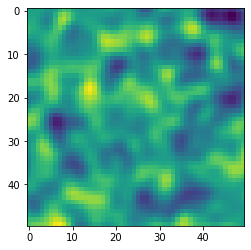

In [3]:
# Specify the contrast matrix (here 2 contrasts are chosen)
C = np.array([[1, -1, 0], [0, 1, -1]])

# Calulate the number contrasts
L = C.shape[0]

# Calculate the number of p-values generated (L for each voxel)
m = nvoxels * L

# Generate a stationary random field with given FWHM
FWHM = 4; lat_data = pr.statnoise(Dim, N, FWHM)

# Alternatively could generate a white noise field
#lat_data = pr.wfield(Dim, N)

# Plot a sample realization of the noise
plt.imshow(lat_data.field[:, :, 1])  

### Add signal to the field

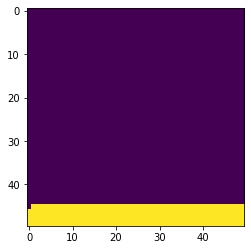

In [4]:
# Obtain the locations where the category is 2
w2 = np.where(categ==2)[0]

# Initialize the spatial signal
pi0 = 0.9  # proportion of noise (true null hypotheses)
p0 = int(np.round(pi0 * nvoxels))
signal = np.zeros(nvoxels)
signal[(p0 + 1): nvoxels] = 0.7
signal = signal.reshape(Dim)

# Add the signal to the field
for I in np.arange(len(w2)):
    lat_data.field[:, :, w2[I]] += signal

# Convert the signal to boolean to determine whether the true signal is
bool_signal = np.zeros(Dim + (L,)) == 0
bool_signal[:, :, 1] = signal > 0 

# Plot the locaion locations for illustration
plt.imshow(signal)

## Posthoc Inference

### Bootstrapping the Data

Bootstrapping is performed using the residuals of the linear model. This gives test-statistics that have the same asymptotic distribution as the limiting test-statistic (under the null). See Eck 2017 and Freedman 1981 for further details. In our context we use these to obtain bootstrapped pivotal statistics which allow us to obtain asymptotic JER control.

In [5]:
# Specify the number of bootstraps to use
B = 500

# Choose the template to use (by default the linear template is chosen)
template = 'linear'

# Run the bootstrapped algorithm (takes a few seconds to run)
minPperm, orig_pvalues, pivotal_stats, bs = pr.boot_contrasts(lat_data, X, C, B, template, True, 1, display_progress=1)

[=================== ] 98%

#### Plotting the p-values

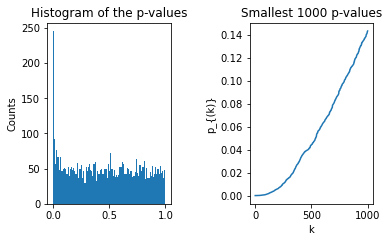

In [6]:
pval_sort_idx = np.argsort(np.ravel(orig_pvalues.field))
pvals = np.ravel(orig_pvalues.field)[pval_sort_idx]

figure, axes = plt.subplots(nrows=1, ncols=2) 
plt.subplot(121)
plt.hist(np.ravel(orig_pvalues.field), 100)
plt.title('Histogram of the p-values')
plt.ylabel('Counts')

npvals = len(pvals)
plt.subplot(122)
plt.plot(pvals[:np.min([1000, npvals])])
plt.title('Smallest 1000 p-values')
plt.xlabel('k')
plt.ylabel('p_{(k)}')

figure.tight_layout(pad=3.0)

#### The bootstrap distribution of the minimum

minPperm is the vector of permuted minimum statistics, importantly it includes the original data as one of the permutations in order to avoid 0 p-values. In particular, for $b = 1, ..., B$, minPperm[b-1] = $\min_{l,v} p^b_{l,v}$ where $p^b_{l,v}$ denotes the $b$th bootstrap of the p-value at voxel $v$ and contrast $l$. We visualize its distribution of the values in minPperm in the following plot. Note that the distribution is skewed to the left because it is the distribution of the minimum of many p-values under the global null.

(array([71., 20.,  4.,  3.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([1.29275728e-07, 1.14909331e-03, 2.29805735e-03, 3.44702138e-03,
        4.59598542e-03, 5.74494946e-03, 6.89391349e-03, 8.04287753e-03,
        9.19184156e-03, 1.03408056e-02, 1.14897696e-02]),
 <a list of 10 Patch objects>)

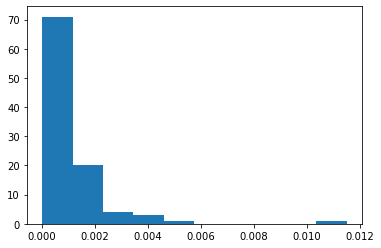

In [7]:
import matplotlib.pyplot as plt
plt.hist(minPperm)

#### The bootstrap distribution of the pivotal statistics

Analogously when seeking to provide simultaneous bounds on the TDP we instead must use quantiles of the pivotal statistics. To do so we can use the vector pivotal_stats. Given a given template family of invertible functions: $(t_k)_{1 \leq k \leq m}$ for $b = 1, ..., B$, we have pivotal_stats[b-1] = $\min_{1 \leq k \leq m} t_k^{-1}(p_{(k:m)}^b)$ where $p_{(k:m)}^b$ is the $b$ th bootstrap of the $k$th minimum p-value. In what follows we shall use the linear template family, which is defined as $t_k(\lambda) = \frac{\lambda k}{m}$.

Earlier today we showed that, given $\alpha \in (0,1)$, taking $\lambda_\alpha^*$ to be the $\alpha$-quantile of the distribution of the pivotal statistics enables us to provide valid simultaneous bounds on the true discovery proportion (TDP) given any subset of the p-values.

(array([ 3.,  6.,  6.,  4.,  8.,  6.,  3.,  8., 11., 45.]),
 array([4.63588690e-04, 1.00413306e-01, 2.00363022e-01, 3.00312739e-01,
        4.00262456e-01, 5.00212173e-01, 6.00161890e-01, 7.00111606e-01,
        8.00061323e-01, 9.00011040e-01, 9.99960757e-01]),
 <a list of 10 Patch objects>)

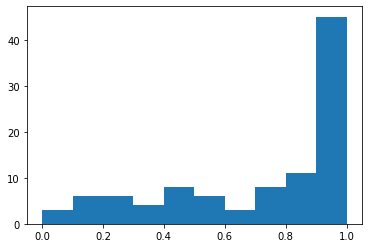

In [8]:
plt.hist(pivotal_stats)

### Lambda Calibration

Using the bootstrapped pivotal_stats that we have calculated we can choose a value lambda that is the $\alpha\%$ quantile of the distribution in order to provide asymptotically valid bounds on the TDP which hold with probability $1-\alpha$.

#### Obtaining the lambda quantile

In [9]:
# Choose the confidence level
alpha = 0.1

# Obtain the lambda calibration
lambda_star_alpha = np.quantile(pivotal_stats, alpha)
print('Lambda Quantile:', lambda_star_alpha)

# Calculate the number of voxels in the mask
nvoxels = np.sum(lat_data.mask)

# Gives t_k(lambda_star_alpha) = lambda_star_alpha*k/npvals for k = 1, ..., npvals
thr = ss.linear_template(lambda_star_alpha, npvals, npvals)

Lambda Quantile: 0.2389932428980469


As we can see from the code below, thr[k-1] = $\frac{\lambda^*_{\alpha}k}{m}$.

In [10]:
print(thr)
print(lambda_star_alpha*(1/m))
print(lambda_star_alpha*(2/m))

[4.77986486e-05 9.55972972e-05 1.43395946e-04 ... 2.38897646e-01
 2.38945444e-01 2.38993243e-01]
4.7798648579609384e-05
9.559729715921877e-05


#### PostHoc Bound

For a chosen subset of voxels we can use this alpha quantile to provide a bound on the number of true null hypotheses within that subset. Try varying the set of p-values used to see how the bound changes.

In [22]:
# Get the first 75 pvalues (or any subset of the p-values)
npvals = 75
subset_pvals = np.sort(np.ravel(orig_pvalues.field))[:npvals]

# Compute an upper bound on the number of null hypotheses
bound = ss.max_fp(subset_pvals, thr)
print('FP upper Bound on subset:', bound)
print('TP lower Bound on subset:', npvals - bound)
print('FDP upper Bound on subset:', bound/npvals)
print('TP lower Bound on subset:', (npvals - bound)/npvals)

confidence = 1-alpha
print('\nWe can thus conclude that with probability', confidence, 'that', npvals - bound, 'of the hypotheses within the given subset are active.')
print('As such we obtain a TDP lower bound of', np.round((npvals - bound)/npvals,2), 'on the proportion of active hypothesis with that subset.')

FP upper Bound on subset: 10.0
TP lower Bound on subset: 65.0
FDP upper Bound on subset: 0.13333333333333333
TP lower Bound on subset: 0.8666666666666667

We can thus conclude that with probability 0.9 that 65.0 of the hypotheses within the given subset are active.
As such we obtain a TDP lower bound of 0.87 on the proportion of active hypothesis with that subset.


You can vary the number 75 to see the difference in the bounds provided. Try also choosing different subsets of p-values to see what bounds you get. If you choose the pvalues where there is signal what bounds do you get?

### Confidence Envelopes

The code below can be used to calculate confidence envelopes. I.e. for i = 1:npvals, max_FP[i-1] is the upper bound on the number of false positives that occur within the set [p[0], \dots, p[i-1]] if you were to reject all elements of that set.

In [12]:
max_FP = ss.curve_max_fp(subset_pvals, thr) # Confidence envelope on the chosen subset
print(max_FP)
max_FP = ss.curve_max_fp(pvals, thr) # Confidence envelope on all of them
print(max_FP[0: 10])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  3.  4.  4.  4.  5.  5.
  5.  6.  6.  6.  6.  7.  7.  7.  8.  8.  8.  8.  8.  8.  9.  9.  9.  9.
  9. 10. 10.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#### Plot the FPR and TP curve bounds

The plot below show the bounds we can provide within the minimum $k$ pvalues, simultaneously over $k$. Try increasing the variable npvals above to zoom out and see a bit more. What happens to the bounds provided as you increase npvals? What is the cause behind this?

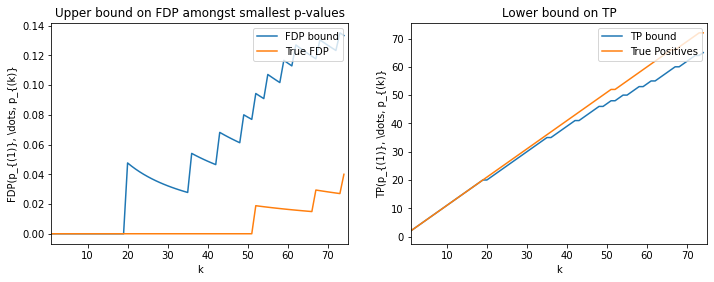

In [23]:
# Choose the number of p-values (always the smallest ones first) to plot
npvals = 75
subset_pvals = np.sort(np.ravel(orig_pvalues.field))[:npvals]
lowestnumber = npvals

# Generate the vector [0,...,npvals]
one2npvals = np.arange(1, npvals + 1)

# Ensure that selected number is not greater than the total number of p-values
lowestnumber = np.min([lowestnumber, npvals])

# Dividing the envelope by the number of elements in the set gives a bound on the false discovery proportion
max_FDP = max_FP[0: lowestnumber] / one2npvals[0: lowestnumber] 
min_TP = one2npvals[0: lowestnumber] - max_FP[0: lowestnumber]

# Calculate the truth (to determine if it is correctly bounded!)
sorted_signal = np.ravel(bool_signal)[pval_sort_idx]
TP = np.zeros(lowestnumber)
for I in np.arange(lowestnumber):
    TP[I] = np.sum(sorted_signal[0: I + 1])
    
# Calculate the true FDP for each subset
FP = np.zeros(lowestnumber)
for I in np.arange(lowestnumber):
    FP[I] = np.sum(abs(sorted_signal[0: I + 1] - 1))
true_FDP = FP / one2npvals[0: lowestnumber] 
    
# Initialize the figure
figure = plt.figure(figsize=(10, 4))

# Plot the false discovery proportion and its bound
plt.subplot(121)
plt.plot(max_FDP, label='FDP bound')
plt.plot(true_FDP, label='True FDP')
plt.title('Upper bound on FDP amongst smallest p-values')
plt.xlim(1, lowestnumber)
plt.xlabel('k')
plt.ylabel('FDP(p_{(1)}, \dots, p_{(k)}')
plt.legend(loc="upper right")

# Plot the true postives and their bound
plt.subplot(122)
plt.plot(min_TP, label='TP bound')
plt.plot(TP, label='True Positives')
plt.title('Lower bound on TP')
plt.legend(loc="upper right")
plt.xlim(1, lowestnumber)
plt.xlabel('k')
plt.ylabel('TP(p_{(1)}, \dots, p_{(k)}')
#figure, axes = plt.subplots(nrows=1, ncols=2) 
figure.tight_layout(pad=1.0)

### Bootstrap curves

Text(0.5, 1.0, 'Plotting the ordered p-values for each bootstrap')

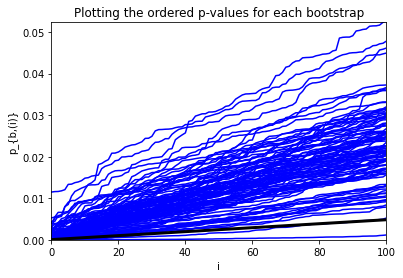

In [31]:
maxbootpval = 0
kmax = 100
kvals = np.arange(kmax)
for b in np.arange(B):
    sorted_bootstraps = np.sort(bs[b,:])
    plt.plot(sorted_bootstraps, color="blue")
    maxbootpval = np.max((maxbootpval, np.max(sorted_bootstraps[:kmax])))
    
plt.plot(thr,color="black", linewidth = 3)
    
plt.xlim(0, kmax)
plt.ylim(0, maxbootpval)
#plt.ylim(0, 0.0005)
plt.xlabel('i')
plt.ylabel('p_{b,(i)}')
plt.title('Plotting the ordered p-values for each bootstrap')


Try to understand what this plot is showing. What do each of the blue lines represent? What is special about the black curve displayed? Try varying kmax to. Try taking kmax to be small in order to zoom in to the bottom left corner of the plot. Take kmax to be large to see how the plot changes.

### Exploring

Go back through the above data example. Try varying parameters like the level of smoothness, $\pi_0$ - the number of null hypotheses, the magnitude of the signal and the shape and size of the signal. Examine the effect of the number of bootstraps (say changing B to 1000), does this have an effect on the bounds provided? Does this effect depend on the magnitude of the signal?

## 3D fMRI Real Data Example

**IMPORTANT:** To participate in this section, you **MUST** sign the 'Data Use Terms'. Please follow the instructions given in [HCP_Access_Form_Instructions.pdf](./HCP_Access_Form_Instructions.pdf).

In [32]:
# Real data directory
import os
from data.download import download_and_extract_zip_from_dropbox
data_dir = os.path.join(os.getcwd(),'data')
real_data_dir = os.path.join(os.getcwd(),'data','example_real_data')

#### Download the data

Download the data - this takes a minute or two.

In [33]:
# Provide Dropbox file URL and Local system path where file needs to be downloaded and extracted.
bold_files, covariates = download_and_extract_zip_from_dropbox(real_data_dir)
data_loc = real_data_dir + '\\HCP_U77_WM\\'

Alternatively if you have already downloaded this data during one of the previous practicals you don't need to run the code in the box above. If so make sure that the data is saved in the real_data_dir directory - if not you may need to change that variable to the location where the data is saved.

In [ ]:
# Only need to run if you already had the data downloaded:
data_loc = real_data_dir + '\\HCP_U77_WM\\'
bold_files = pr.list_files(data_loc, '.nii.gz', 1)

This dataset was derived from the Wu-Minn HCP working memory task. Here is some further detail on the task itself.

**The Task**

In the experiment, 77 unrelated subjects performed two tasks spread across two runs where each run contained four blocks. During each block, the subject undertook either a 2-back memory task or a 0-back control task. The experimental design was arranged such that, in each run, two blocks were designated to the 2-back memory task, and two blocks were designated to the 0-back control task. In each block a subject was shown a stimuli image (a picture of a face or a place, for instance) and then asked to recall the image they were shown. They were either asked to recall the most recent image (the '0-back' image) or the image shown to them two images prior (the '2-back' image). Interest lies in assessing whether this delay impacted the \%BOLD response.

**First-level Analysis**

In FSL, a first-level analysis has been conducted independently for each subject. In each first-level analysis, the task design was regressed onto Blood Oxygenation Level Dependent (BOLD) response and a Contrast Parameter Estimate (COPE) map was generated. Each COPE map represents, for a given subject, the difference in BOLD response between the subject performing the 2-back task and the 0-back task (e.g $L\hat{\beta}=\hat{\beta}_{\text{2-Back}}-\hat{\beta}_{\text{0-Back}})$).

**Acquisition Details**

All image acquisitions were obtained using a $32$ channel head coil on a modified $3T$ Siemans Skyra scanner via a gradient-echo EPI sequence with TR $=720$ ms, TE $=33.1$ ms, $2.0$ mm slice thickness, $72$ slices, $2.0$ mm isotropic voxels, $208$ mm $\times 180$ mm FOV, and a multi-band acceleration factor of $8$.

**The Data**

You have the COPE map for each subject and the following covariates for each subject, both sorted by subject ID.
 - `Age`: The subject's age.
 - `Sex`: The subject's biological sex, with male encoded as `0` and female encoded as `1`.
 - `PMAT24_A_CR`: The number of correct responses from the Penn Progressive matrices; a measure of the subject's fluid intelligence.
 
For more information on these variables, please visit [this link](https://wiki.humanconnectome.org/display/PublicData/HCP-YA+Data+Dictionary-+Updated+for+the+1200+Subject+Release). Here is a brief view of the data.


**The Task**

The task is to fit the following model at each voxel $v$ and to provide TDP bounds on selected regions. 

$$Y(v) = \beta_0 + \text{Sex} \beta_1 + \text{Age} \beta_2 + \text{PMAT24_A_CR} \beta_3 $$

To do so you need to load in the data and run the methods above to obtain a lambda calibration. You can then select subset of the data of your choosing and provide bounds on the number of true postives in each subset.

Feel free to look at the data first. The bounds are valid for any subset, including data-driven ones.


First we will load the data into memory and apply some smoothing.

In [34]:
from nilearn.image import get_data, load_img
from nilearn.input_data import NiftiMasker
fwhm = 5 # Set the smoothness parameter (in mm)
mask = data_dir + '\\mask_GM_forFunc.nii'
masker = NiftiMasker(smoothing_fwhm=fwhm, mask_img=mask).fit()
data = masker.transform(bold_files).transpose()

Let's now plot the mean of the data

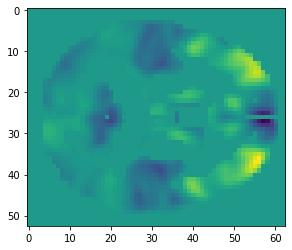

In [37]:
data_mean = np.mean(data, 1)
data_mean_3d = np.squeeze(
    get_data(masker.inverse_transform(data_mean.transpose())))
plt.imshow(data_mean_3d[:,:,23])

(array([1.600000e+01, 6.300000e+01, 9.630000e+02, 2.178700e+04,
        3.021874e+06, 1.339949e+06, 1.513500e+04, 6.290000e+02,
        5.200000e+01, 5.000000e+00]),
 array([-372.57666 , -296.44403 , -220.3114  , -144.17877 ,  -68.04614 ,
           8.086487,   84.21912 ,  160.35175 ,  236.48438 ,  312.617   ,
         388.74963 ], dtype=float32),
 <a list of 10 Patch objects>)

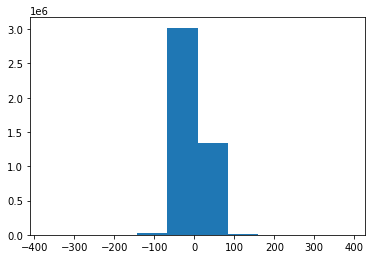

In [38]:
plt.hist(np.ravel(data))

Next we will load in the covariates. The covariates file: 'behavioural_data_subset_77.csv' corresponds to a subset of the unresticted covariates of the 77 subjects. The full set of unrestricted is available on the HCP website MAKE LINK!

In [41]:
import pandas as pd
pd_data = pd.read_csv(
    data_loc + 'behavioural_data_subset_77.csv')
print(pd_data)
design = np.zeros((77, 4))
design[:, 1:4] = pd_data.values[:, 1:4]

# Add an intercept:
design[:, 0] = 1

    Subject  Sex   Age  PMAT24_A_CR  PSQI_Score
0    100307    1  28.0           17           4
1    100408    0  33.0            7           4
2    101915    1  33.0           21           6
3    103414    1  23.5           17           9
4    105115    0  33.0           22           6
..      ...  ...   ...          ...         ...
72   856766    1  33.0           10          11
73   857263    0  23.5            8           0
74   871964    0  28.0           23           3
75   899885    1  28.0           20           8
76   984472    1  28.0           22           5

[77 rows x 5 columns]


Try exploring the above covariates to get a better idea of their distribution.

In [43]:
data_field = pr.make_field(data.copy())

# Obtain the number of subjects
nsubj = data_field.fibersize

contrast_matrix = np.array((0,0,0,1))
n_params = 4

# Obtain the test statistics and convert to p-values
test_stats, _ = pr.contrast_tstats(data_field, design, contrast_matrix)

# pvalues = 2*(1 - t.cdf(abs(test_stats.field), nsubj-n_params))
pvalues = pr.tstat2pval(test_stats.field, nsubj-n_params, 1)

tstat_3d = np.squeeze(
    get_data(masker.inverse_transform((test_stats.field).transpose())))

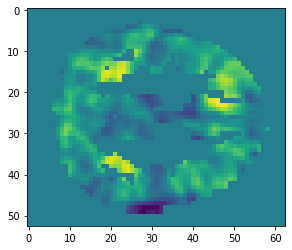

In [44]:
plt.imshow(tstat_3d[:,:,29])

(array([11452.,  7582.,  6389.,  5904.,  5417.,  5038.,  4703.,  4214.,
         3567.,  2883.]),
 array([5.40479434e-06, 9.99824890e-02, 1.99959573e-01, 2.99936657e-01,
        3.99913742e-01, 4.99890826e-01, 5.99867910e-01, 6.99844994e-01,
        7.99822079e-01, 8.99799163e-01, 9.99776247e-01]),
 <a list of 10 Patch objects>)

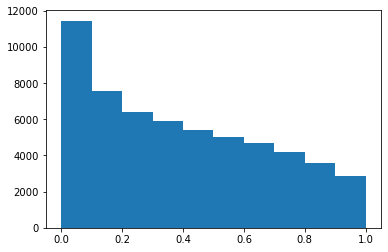

In [45]:
plt.hist(pvalues)

In [55]:
n_bootstraps = 100
minPperm, origpvals, pivotal_stats, bootstore = pr.boot_contrasts(
    data.copy(), design, contrast_matrix, n_bootstraps=n_bootstraps,
    display_progress=1, store_boots=1, doonesample=1)

[=================== ] 99%

In [56]:
alpha = 0.2
lambda_quant = np.quantile(pivotal_stats, alpha)
nhypotheses = np.prod(origpvals.field.shape)

sorted_pvalues = np.sort(origpvals.field, 0)
pvalue_subset = sorted_pvalues[0:700] # Chose a subset of the smallest p-values

FP_bound, TP_bound, FDP_bound, TDP_bound = pr.get_bounds(
    pvalue_subset, lambda_quant, nhypotheses)

confidence = 1-alpha
print('\nWe can thus conclude that with probability', confidence, 'that', TP_bound, 'of the hypotheses within the given subset are active.')
print('As such we obtain a TDP lower bound of', np.round(TDP_bound,2), 'on the proportion of active hypothesis with that subset.')


We can thus conclude that with probability 0.8 that 483.0 of the hypotheses within the given subset are active.
As such we obtain a TDP lower bound of 0.69 on the proportion of active hypothesis with that subset.


Let us now exmaine some of the superthreshold clusters. To do so we choose a cluster defining threshold, 2 and a minimum clustersize.

In [57]:
mask_im = load_img(mask).get_fdata()
cluster_defining_threshold = 2
min_cluster_size = 500
cluster_im, cluster_sizes = pr.find_clusters(tstat_3d, cluster_defining_threshold, below=0, mask=mask_im, min_cluster_size = min_cluster_size)
print(cluster_sizes)

[799. 650. 647.]


In [58]:
# Compute the TP bounds within the clusters
pvalues_3d = np.squeeze(
    get_data(masker.inverse_transform(pvalues.transpose())))

cluster_number = 1 # Can change this to be 1, 2 or 3
region_idx = cluster_im == cluster_number
FP_bound, TP_bound, FDP_bound, TDP_bound = pr.get_bounds(
    pvalues_3d[region_idx], lambda_quant, nhypotheses)
confidence = 1-alpha
print('\nWe can thus conclude that with probability', confidence, 'that', TP_bound, 'of the hypotheses within the chosen cluster are active.')
print('As such we obtain a TDP lower bound of', np.round(TDP_bound,2), 'on the proportion of active hypothesis with that cluster.')


We can thus conclude that with probability 0.8 that 92.0 of the hypotheses within the chosen cluster are active.
As such we obtain a TDP lower bound of 0.12 on the proportion of active hypothesis with that cluster.


We can thus conclude that with 80% = 100(1-$\alpha$)% probability the largest cluster contains a number of active voxels. Instead for for the second largest cluster (set cluster_number = 2 to see this) we are only able to say that there is at least 1 active voxel and for the third largest (cluster_number = 2) we cannot provide an interesting lower bound. This gives us a greater insight into the contents of each cluster, something that clustersize inference would not be able to do. Try varying the cluster defining threshold to see how the conclusions change.

We plot the largest cluster below for reference

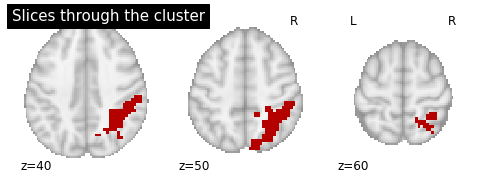

In [54]:
from nilearn import plotting
region_idx_plot = 0.5*region_idx
region_idx_nifti = masker.inverse_transform(region_idx_plot[mask_im>0])
plotting.plot_stat_map(
        region_idx_nifti,
        display_mode='z', vmax=2, colorbar = False,
        title='Slices through the cluster', cut_coords=[40, 50, 60])

Note that if the above code doesn't run, it may be because you need to upgrade matplotlib. To do so run the following code and then try the example above.

In [ ]:
%pip install matplotlib --upgrade

#### Reflecting on the inference

If you decrease the value of alpha, the bounds on the number of active voxels decrease. In order to increase the signal to noise ratio, either additional smoothing can be applied. Alternatively a larger dataset can be used. The HCP dataset consists of 1200 subjects in total so if they could all be used then it would be easier to find an interesting effect. Here we only use a subset of 77 for computational ease in the practical.

## Experimenting

Can you plot a confidence curve plot for the TDP?

Can you think of other contrasts that could be of interest here? Experiment with changing the contrast_matrix. How about other models? 

You can also test how varying the smoothness affects the results. Increasing the amount of smoothing increases the signal to noise ratio and will give you more power at the price of spatial specificity.

Try increasing the number of bootstraps, does this make any difference?

Note that the simultaneity gaurantees assume a fixed level of smoothing. In order to provide simultaneous guarantees over multiple smoothing levels the joint distribution pvalues over the different smoothing levels would have to be bootstrapped. This is possible but is not implemented here.